# Code of Part 4 in TensorFlow

In this repository, we will replicate the code from our Machine Learning Guide for Petroleum Professionals: Part 4 using TensorFlow. We have previously covered the Deep Learning from scratch using Numpy. If you are interested, you can read Part 4 of the guide  [here](https://jpt.spe.org/twa/machine-learning-guide-for-petroleum-professionals-part-4). Additionally, you can access the corresponding code from scratch on [GitHub](https://github.com/saifkhanengr/Machine-Learning-Guide-for-Petroleum-Professionals-Part-4/blob/main/Code%20of%20Part%204.ipynb). Without further ado, let's start reproducing the code in TensorFlow.

Before I start, I would like to thank Professor [Michael Pyrcz](https://www.linkedin.com/in/michael-pyrcz-%F0%9F%87%BA%F0%9F%87%A6-61a648a1/) of the University of Texas at Austin for generously providing me the porosity and permeability data. The complete dataset is available [here](https://zenodo.org/record/5564874#.Y_4VCHZBzCY).

First, import the necessary libraries and Framework (TensorFlow)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  

## Import data
Same as in part 4

In [2]:
data = pd.read_csv('Stochastic_1D_por_perm_demo.csv')
data_top_bottom = pd.concat([data.head(5), data.tail(5)])
table_style = [{'selector': 'th', 'props': [('background-color', '#4287f5'), ('color', 'white'), ('font-size', '14px'), ('border', '1px solid black')]},
               {'selector': 'td', 'props': [('border', '1px solid black'), ('font-size', '14px'), ('text-align', 'center')]}]
styled_table = data_top_bottom.style.set_table_styles(table_style)
styled_table

,Unnamed: 0,Porosity,Permeability
0,0,13.746408,193.721529
1,1,9.608479,105.718666
2,2,11.664361,138.539297
3,3,8.375338,93.719985
4,4,13.183358,169.738824
100,100,8.042614,84.564471
101,101,19.887759,453.228801
102,102,11.118544,128.606149
103,103,16.051620,265.341789
104,104,17.762477,337.335817


## Dropping Unnamed: 0 column and checking null

In [3]:
data = data.drop(data.columns[0], axis=1)
null_values = data.isnull().sum()

print(f"Null values: {null_values}")

Null values: Porosity        0
Permeability    0
dtype: int64


## Defining X as Porosity, Y as Permeability, and Scaling the data

In [4]:
X = data["Porosity"]
Y = data["Permeability"]
X = X.values.reshape(-1,1)
Y = Y.values.reshape(-1,1)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
X = X/np.max(X)

X shape: (105, 1)
Y shape: (105, 1)


## Ploting Porosity and Permeability

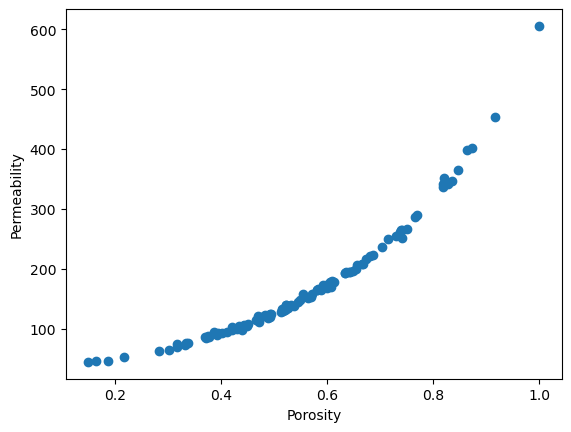

In [5]:
plt.scatter(X,Y)
plt.xlabel("Porosity")
plt.ylabel("Permeability")
plt.show()

## Splitting Data into training and testing sets

In [6]:
def split_data(X, Y):
    total_samples = X.shape[0]
    train_samples = int(0.8 * total_samples)
    test_samples = int(0.20 * total_samples)

    X_train = X[:train_samples]
    Y_train = Y[:train_samples]

    X_test = X[train_samples:train_samples+test_samples]
    Y_test = Y[train_samples:train_samples+test_samples]
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = split_data(X, Y)

X_train shape: (84, 1)
Y_train shape: (84, 1)
X_test shape: (21, 1)
Y_test shape: (21, 1)


## Callback
We will use TensorFlow callback function to stop our training when our desired output is achieved. In this case, when the Mean Absolute Error (MAE) of our model predicted values and the true values of permeability is less than or equal to 5, we will stop the training.

In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('mae') is not None and logs.get('mae') <7:
            self.model.stop_training = True

Next, we will define our own custom accuracy function as TensorFlow's "accuracy" metric is design for Classification problem and do not work in Regression problem (this one).

In [8]:
def custom_accuracy(Y, Y_pred):
    error = (np.abs(Y_pred - Y))/(np.abs(Y))
    avg_error = np.mean(error)
    percent_error = avg_error*100
    accuracy = (1 - avg_error)*100.0
    return accuracy

Now we will define a function `train_model`. In this function, we are defining three-layer model having three, five, and one neurons respectively. Learning rate is 0.0001. All these are the same as of Model 4 of our Numpy code. 

In [9]:
def train_model(X_train, Y_train):
    
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='relu', input_shape=(1,),kernel_initializer=tf.keras.initializers.he_normal(seed_value),name='1st_layer'),
    tf.keras.layers.Dense(5, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed_value),name='2nd_layer'),
    tf.keras.layers.Dense(1,kernel_initializer=tf.keras.initializers.he_normal(seed_value), name='3rd_layer')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(0.0001), 
                  loss='mse', 
                  metrics=['mae'])
    
    callbacks = myCallback()
    history = model.fit(X_train, Y_train, epochs=5001,verbose=0, callbacks=[callbacks])

    num_iterations = len(history.epoch)
    for i, cost in enumerate(history.history['loss']):
        mae = history.history['mae'][i]
        if i % 100 == 0:
            print("Train Cost after iteration {}: {}".format(i, cost))
            print("Train MAE after iteration {}: {}".format(i, mae))
    
    if history.history['mae'][-1] < 7:
        print("\033[1mReached MAE < 7 so cancelling training!\033[0m")
        print("Last MAE: {:.4f}".format(history.history['mae'][-1]))

    Y_pred = model.predict(X_train)
    accuracy = custom_accuracy(Y_train, Y_pred)
    print("Train Accuracy is:", accuracy)
    
    """Uncomment the below code to see the values of shapes of weights and bias
    weights = model.get_weights()
    for i in range(1, 4):
        layer_weights = weights[i*2-2]
        layer_bias = weights[i*2-1]
        print(f"Weights of layer {i}:")
        print(layer_weights)
        print(f"shape {layer_weights.shape}")
        print(f"Bias of layer {i}:")
        print(layer_bias)
        print(f"shape {layer_bias.shape}")"""
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train, Y_train, marker='o', c='blue', label='Actual Value')
    plt.scatter(X_train, Y_pred, marker='o', c='red', label='Predicted Value')
    plt.xlabel("Porosity")
    plt.ylabel("Permeability")
    plt.legend()
    plt.show()
         
    return history

In the below cell, I am setting the seed value to 42, an arbitrary choice, so we can get the same results everytime we run the cell.

In [10]:
seed_value = 42
tf.random.set_seed(seed_value)

## Training our Model

Train Cost after iteration 0: 34072.24609375
Train MAE after iteration 0: 163.15231323242188
Train Cost after iteration 100: 840.1486206054688
Train MAE after iteration 100: 18.134292602539062
Train Cost after iteration 200: 902.8462524414062
Train MAE after iteration 200: 19.743574142456055
Train Cost after iteration 300: 800.3756713867188
Train MAE after iteration 300: 20.38481903076172
Train Cost after iteration 400: 692.3524169921875
Train MAE after iteration 400: 15.523210525512695
Train Cost after iteration 500: 582.508544921875
Train MAE after iteration 500: 14.756497383117676
Train Cost after iteration 600: 362.00408935546875
Train MAE after iteration 600: 11.825353622436523
Train Cost after iteration 700: 220.98348999023438
Train MAE after iteration 700: 8.47287368774414
Reached MAE < 7 so cancelling training!
Last MAE: 6.9432
3/3 [==============================] - 0s 3ms/step
Train Accuracy is: 92.11009819769157


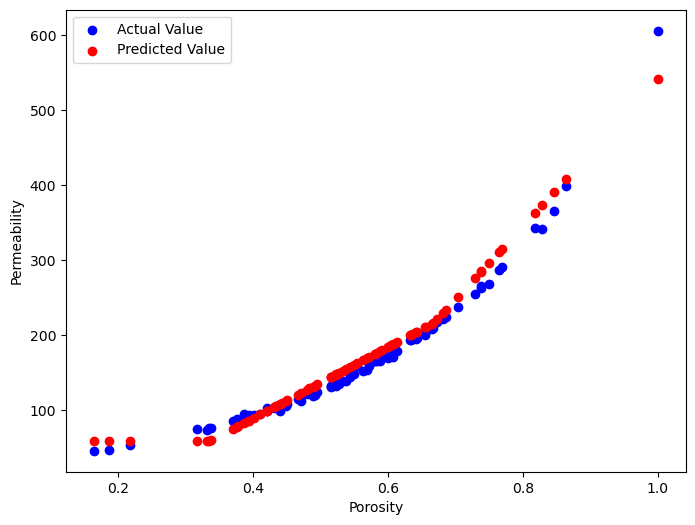

In [11]:
hist = train_model(X_train, Y_train)

See! Our model  automatically stopped training when MAE reached < 7. Within 700 iterations, saved us from unnecessary additional 4300 iterations. And, our training accuracy is 92.11%.Good to go. Now check out the testing accuracy.

The below function will evaluate our trained model and compare it's results with the test data

In [12]:
def evaluate_model(model, X_test, Y_test):
    loss = model.evaluate(X_test, Y_test)[0]
    print("Test Loss:", loss)
    MAE = model.evaluate(X_test, Y_test)[1]
    print("Test MAE:", MAE)

    Y_pred = model.predict(X_test)
    accuracy = custom_accuracy(Y_test, Y_pred)
    print("Test Accuracy is:", accuracy)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_test, Y_test, marker='o', c='blue', label='Actual Value')
    plt.scatter(X_test, Y_pred, marker='o', c='red', label='Predicted Value')
    plt.xlabel("Porosity")
    plt.ylabel("Permeability")
    plt.legend()
    plt.show()
    
    df = pd.DataFrame({"Actual Permeability": np.squeeze(Y_test), "Predicted Permeability": np.squeeze(Y_pred)})
    data_top_bottom = pd.concat([df.head(5), df.tail(5)])
    table_style = [{'selector': 'th', 'props': [('background-color', '#4287f5'), ('color', 'white'), ('font-size', '14px'), ('border', '1px solid black')]},
                   {'selector': 'td', 'props': [('border', '1px solid black'), ('font-size', '14px'), ('text-align', 'center')]}]
    styled_table = data_top_bottom.style.set_table_styles(table_style)
    display(styled_table)


1/1 [==============================] - 0s 298ms/step - loss: 256.9063 - mae: 13.5333
Test Loss: 256.9063415527344
1/1 [==============================] - 0s 46ms/step - loss: 256.9063 - mae: 13.5333
Test MAE: 13.53326416015625
1/1 [==============================] - 0s 152ms/step
Test Accuracy is: 91.34431733027017


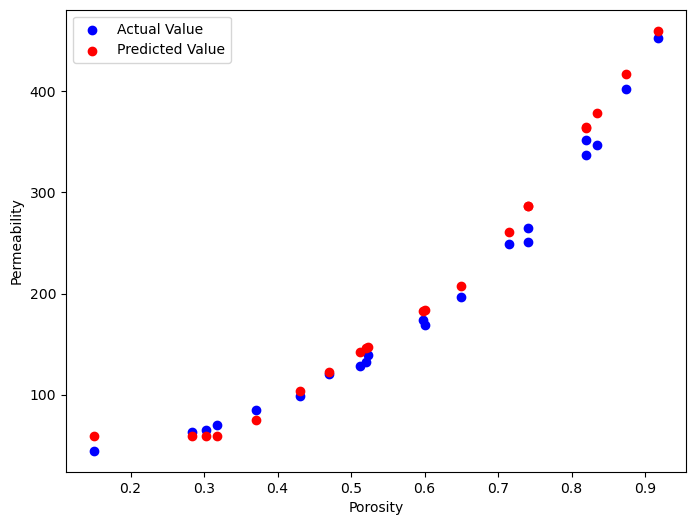

,Actual Permeability,Predicted Permeability
0,65.227602,58.686630
1,98.809947,103.310379
2,173.684221,182.689392
3,251.375148,287.007080
4,120.779829,122.044136
16,84.564471,74.815529
17,453.228801,460.068420
18,128.606149,142.208694
19,265.341789,286.225098
20,337.335817,363.756409


In [13]:
evaluate_model(hist.model, X_test, Y_test)

So, testing accuracy is 91.34%. Not overfitting.

Try tunning the hyperparameters and running this code with your own data (or with this data).